**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*

Music is known to bring people with a similar taste together in masses at the concerts of world-famous artists. However, as all matters of taste, there exists a multitude of different genres which are more or less separable. For example, hardly anyone would state that power metal and smooth jazz sounded alike, mainly because of the clear difference in tempo. 

For the purposes of this project, we focus on three different components, namely timbre, pitch and rhythm. Timbre describes the tonal colour, which separates heavily distorted electic guitar from a clean piano. Pitch describes how low or high a sound is, separating very low notes found in bass-heavy electronic music from the high-pitched flutes in some classical pieces. Finally, rhythm describes the temporal structure of a given piece of music, like in the example given before. 

Multiclass classification is a branch of machine learning with the purpose of creating classifications where similar items are grouped together. The basic idea in classification is to figuratively draw lines separating one class from all the other data. A rough example of this would be to say that all pictures that have a high enough level of green have grass in them. Multiclass classification is then performed by combining the information from many one-vs-all classifications. TODO: a figure here? 

In this project, our goal is to create a classifier that gives us the probability of each song belonging to ten different music genres using a given training dataset described in the next section. This classifier is then used to predict the genres of songs in a test set, and we aim for the highest possible predictive accuracy. 



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*


The training data consists of 4363 songs from 10 genres with 264 features for each song. The first things we want to check from our training data are the class distribution and the principal component analysis. The class distribution shows us if the data consists of equal proportions of each genre or not, while the principal component analysis and the reconstruction error show us whether the number of features could be reduced. By looking at the first principal components, it is also possible to understand what features really separate the classes from each other. The songs furthest away from each other on the first principal component would surely sound very different if we could listen to them.

We start the report with importing all the necessary packages and defining utility functions used throughout the project.

In [2]:
'''
Dependencies
'''
# Import dependencies
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import metrics as met
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split as TTSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report as ClassRep
from sklearn.metrics import confusion_matrix as ConfMat
from sklearn.linear_model import Perceptron, LogisticRegression as LogReg
from sklearn import preprocessing, svm, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
'''
The utility functions used throughout the project
'''

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Modified a bit
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues,
                          print_matrix = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        if print_matrix: print("Normalized confusion matrix")
    else:
        if print_matrix: print('Confusion matrix, without normalization')

    if print_matrix: print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Write results to excel files for analysis
def output(acc, logloss, name):
    # Check input
    if (acc.shape != (6544,)) or (logloss.shape != (6544, 10)):
        print('wrong input shapes')
        return
    
    df_acc = pd.DataFrame(acc, index = pd.Series(range(1, 6545), name = 'Sample_id'), columns = ['Sample_label'])
    df_logloss = pd.DataFrame(logloss, index = pd.Series(range(1, 6545), name = 'Sample_id'), 
        columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 
                   'Class_8', 'Class_9', 'Class_10'])
    
    # Excel file for analysis
    writer = pd.ExcelWriter(name+'.xlsx', engine = 'xlsxwriter')
    df_acc.to_excel(writer, sheet_name = 'accuracy')
    df_logloss.to_excel(writer, sheet_name = 'logloss')
    writer.save()
    
    # Kaggle submissions
    df_acc.to_csv(name+'_acc.csv')
    df_logloss.to_csv(name+'_logloss.csv')

# Compute PCA
def compute_pca(Z, d):
    # Input: the N by D data matrix Z, the number of components d
    # Output: a d by D matrix W_pca, and all eigenvalues of Q
    
    # step1: compute the sample cov. matrix Q
    Q = Z.T.dot(Z) / Z.shape[0]

    #step2: compute the eigenvalues and eigenvectors (see introduction notebook)
    eigvalues, eigvectors = np.linalg.eig(Q)
    eigvectors = eigvectors.T
    
    #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
    W_pca = np.asarray([x for _, x in sorted(zip(eigvalues,eigvectors), key = lambda pair: -pair[0].real)][:d])
    
    return W_pca.real, eigvalues

# Visualize PCA error
def plot_error(eigvalues, max_d):
    x = range(1, max_d + 1)
    errors = [sum(eigvalues[d:]) for d in x]
    plt.plot(x, errors)
    plt.xlabel('Principal Components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Principal Components vs. the Reconstruction Error')
    plt.show()
    

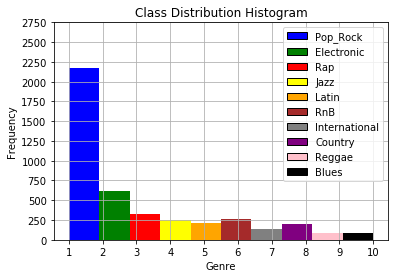

In [4]:
'''
Data Import from Files
'''

# Reading Data into Numpy Arrays
XTrainData = pd.read_csv("train_data.csv", header = None).values
YTrainData = pd.read_csv("train_labels.csv", header = None).values
XTestData = pd.read_csv("test_data.csv", header = None).values

# Storing Numpy Arrays into DataFrames for better visualization
FeatureTrainData = pd.DataFrame(XTrainData)
LabelTrainData = pd.DataFrame(YTrainData)
FeatureTestData = pd.DataFrame(XTestData)

#FeatureTrainData.head()
#FeatureTestData.head()
#LabelTrainData.head()

# Class Distribution Histogram 
fig, ax = plt.subplots()
N, bins, patches = ax.hist(YTrainData, linewidth = 2)
plt.title("Class Distribution Histogram")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(np.arange(1, 11, step = 1))
plt.yticks(np.arange(0, 3000, step = 250))
colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']
for i in range(0, 10):
    patches[i].set_facecolor(colors[i])
# Histogram Legend
handles = [Rectangle((0, 0), 1, 1, color = c, ec = "k") for c in colors]
labels = ["Pop_Rock", "Electronic", "Rap", "Jazz", "Latin", "RnB", "International", "Country", "Reggae", "Blues"]
plt.legend(handles, labels)
plt.show()

From the class distribution histogram, it is obvious that the training data is heavily skewed towards pop/rock, as more than half of the data (TODO: percentage) is in the class. This is problematic if the test data is distributed differently, as classifiers trained with this data will probably classify many songs from other genres as pop/rock in order to increase accuracy. This has to be taken into account in training the models in order to get proper predictions.

In [5]:
'''
Data Normalization (Choose one and comment out the others for testing)
'''

# Initialization of Scalers/Transformers/Normalizers
standard_scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
normalize = preprocessing.Normalizer()
quantile_transformer = preprocessing.QuantileTransformer(random_state = 0)


# Choice of Scaling/Transforming/Normalizing (Default = Standard Scaler)
choice = 1

if choice == 1: 
    # Normalize the data with standard
    XTrainData = standard_scaler.fit_transform(XTrainData)
    XTestData = standard_scaler.fit_transform(XTestData)
elif choice == 2:
    # Normalize the data with minmax
    XTrainData = min_max_scaler.fit_transform(XTrainData)
    XTestData = min_max_scaler.fit_transform(XTestData)
elif choice == 3:
    # Normalize the data with robust scaler
    XTrainData = robust_scaler.fit_transform(XTrainData)
    XTestData = robust_scaler.fit_transform(XTestData)
elif choice == 4:
    #Normalize the data with Normalize
    XTrainData = normalize.fit_transform(XTrainData)
    XTestData = normalize.fit_transform(XTestData)
else:
    # Scale data onto Uniform Distribution [0, 1]
    XTrainData = quantile_transformer.fit_transform(XTrainData)
    XTestData = quantile_transformer.fit_transform(XTestData)

'''
Data Splits (Test and Train Sets)
'''

# Split choice (Normal = 0, Stratified K-Fold = 1)
split_choice = 1

# Multiple split ratios for test purposes 
splitRatios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

if split_choice == 0:
    # Splitting the Test Data into Training and Testing Sets (both Features and Labels) (Normal)
    XTrainSet, XTestSet, YTrainSet, YTestSet = TTSplit(XTrainData, YTrainData, test_size = splitRatios[2])
elif split_choice == 1:
    # Splitting the Test Data into K Training, Validation and Testing Sets (both Features and Labels) (Stratified K-Fold)
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    skfSplits = skf.split(XTrainData, YTrainData)

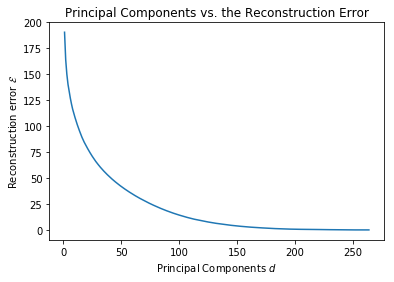

In [6]:
# Data has 264 features, calculate PCA and eigenvalues up to a full reconstruction
PCA, eigvalues = compute_pca(XTrainData, 264)

# plot the number of principal components vs the reconstruction error
plot_error(eigvalues, 264)

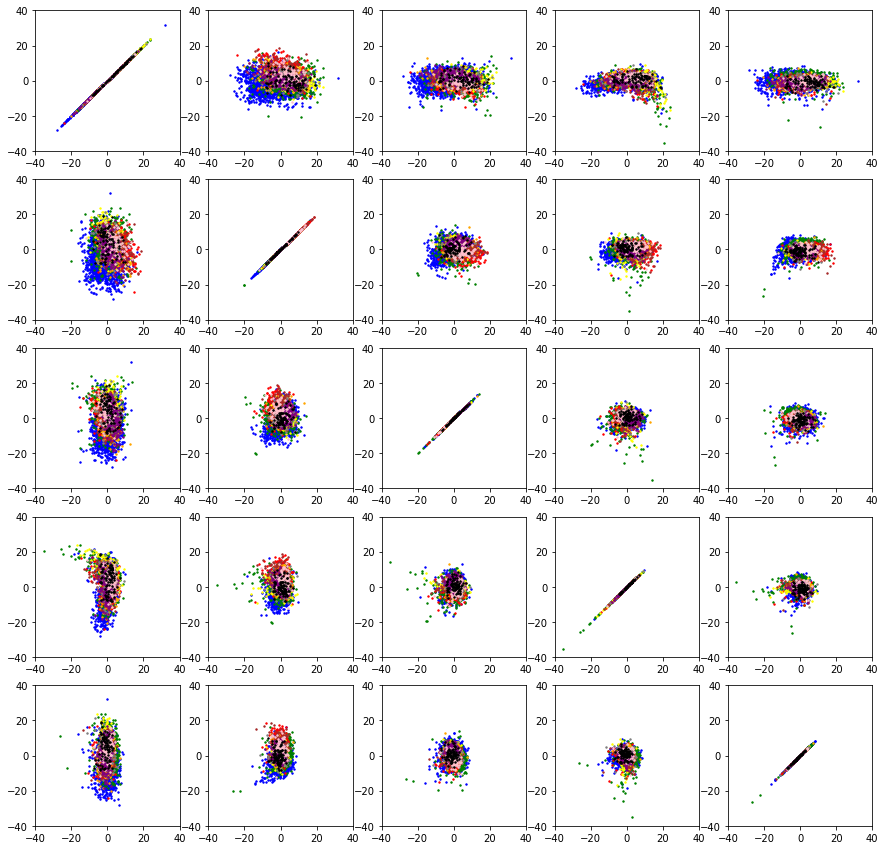

In [10]:
def plot_scatter(PCA, Z, Y):
    # get x for d = 10
    X_10d = np.matmul(PCA[:10, :], Z[:, :, None])[:, :, 0]
    colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']
    fig, axes = plt.subplots(5, 5)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(5):
        for j in range(5):
            for class_id in range(len(labels)):
                axes[i, j].scatter(X_10d[np.where(Y == class_id + 1),i], X_10d[np.where(Y == class_id + 1),j],
                                   marker = 'o', s = 2, c = colors[class_id], label = labels[i])
                axes[i, j].set_xlim([-40, 40])
                axes[i, j].set_ylim([-40, 40])
    plt.show()
    

plot_scatter(PCA, XTrainData, YTrainData)

From the principal component analysis, we can see that using half the original number of features, the reconstruction error is only around 10% of the maximum. This dimension reduction would mostly be beneficial in decreasing the running times, but as running times were no problem, we used the full data instead. From the scatterplots, we can see that in the first two principal directions, pop/rock is focused in the smaller values, and in directions 4 and 5, electronic music has some slight outliers. When examining the first principal component, it is visible that in the first 168 coefficients, there is an oscillation with a period of 24. Additionally, the next 48 clearly come in sets of 12 consecutive coefficients. What these observations mean is that the rhythm has an effect that is dependent on the band, with different weights for the 7 statistics. The coefficients for chroma do not seem to depend on the semitone, but only on the statistic 1-4. The effect of timbre is much less obvious in the first principal component.

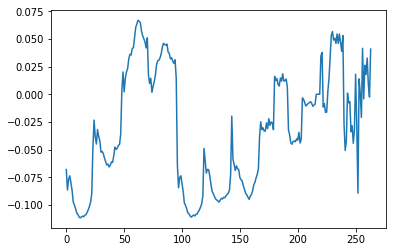

In [17]:
# This is not finalized, the point is to show the weights of coefficients in the given principal component.
plt.plot(PCA[0])
pd.DataFrame(PCA[0]).to_csv('pca.csv')

In [9]:
''' 
Multinomial Logistic Regression with Multiple Iterations
PARAMETERS:
    Iterations = 7500
    Inverse Regularization Constant = 0.1 till 10
    Solver = SAG
    Penalty = L2
'''

# Metrics Initialization
C = 0.001
testAcc = []
validAcc = []
validLogloss = []
C_array = []
best_score = 0
best_C = 0.001
    
'''
Stratified K-Fold Accuracy check to fetch best splits
'''

if split_choice == 1:
    bestAcc = 0
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    for train_index, test_index in skf.split(XTrainData, YTrainData): 
        XTrainSet, XTestSet = XTrainData[train_index], XTrainData[test_index] 
        YTrainSet, YTestSet = YTrainData[train_index], YTrainData[test_index]
        logreg = LogReg(C = 0.1, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
        logreg.fit(XTrainSet, YTrainSet.ravel())
        predictTrain = logreg.predict(XTrainSet)
        print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
        print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)), '\n')
        if met.accuracy_score(YTestSet, logreg.predict(XTestSet)) > bestAcc:
            train_idx = train_index
            test_idx = test_index
            bestAcc = met.accuracy_score(YTestSet, logreg.predict(XTestSet))
    XTrainSet, XTestSet = XTrainData[train_idx], XTrainData[test_idx] 
    YTrainSet, YTestSet = YTrainData[train_idx], YTrainData[test_idx]

while C < 0.1:
    logreg = LogReg(C = C, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)

    # Fitting the refined training sets 
    logreg.fit(XTrainSet, YTrainSet.ravel())

    # Calculation of training accuracy
    predictTest = logreg.predict(XTestSet)
    predictTrain = logreg.predict(XTrainSet)

    # Display the calculated accuracies
    print('Inverse of Regularization Constant (C): ', C)
    print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainSet))
    print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestSet))
    testAcc.append(met.accuracy_score(predictTrain, YTrainSet))
    validAcc.append(met.accuracy_score(predictTest, YTestSet))
    validLogloss.append(met.log_loss(YTestSet, logreg.predict_proba(XTestSet)))
    C_array.append(C)
    
    # Display final score from Logistic Regression
    score = logreg.score(XTestSet, YTestSet)
    print('Final Score: ', score, '\n')
    
    # Set best parameters for alogrithm tuning 
    if score >= best_score:
        best_score = score
        best_C = C
        
    # Increment C for next iteration
    C = C * 1.2

Validation Accuracy:  0.6488027366020525
Validation Log-loss:  1.1682659970540086 

Validation Accuracy:  0.6750572082379863
Validation Log-loss:  1.1191455573641942 

Validation Accuracy:  0.6494845360824743
Validation Log-loss:  1.0984754810400144 

Validation Accuracy:  0.6505747126436782
Validation Log-loss:  1.1554081555294289 

Validation Accuracy:  0.6363636363636364
Validation Log-loss:  1.1488172070388716 

Inverse of Regularization Constant (C):  0.001
Training Accuracy:  0.6305531670965893
Testing Accuracy:  0.6361556064073226
Final Score:  0.6361556064073226 

Inverse of Regularization Constant (C):  0.0012
Training Accuracy:  0.6362854686156492
Testing Accuracy:  0.6361556064073226
Final Score:  0.6361556064073226 

Inverse of Regularization Constant (C):  0.0014399999999999999
Training Accuracy:  0.6420177701347091
Testing Accuracy:  0.6418764302059496
Final Score:  0.6418764302059496 

Inverse of Regularization Constant (C):  0.0017279999999999997
Training Accuracy:  0.6

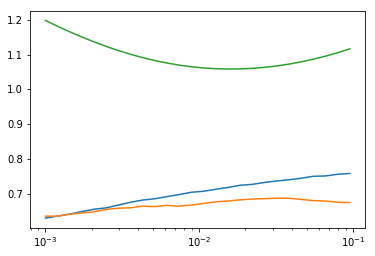

In [10]:
'''
Accuracy Plot for multiple Multinomial Logistic Regression Classifications
'''
plt.figure()
plt.plot(C_array,testAcc)
plt.plot(C_array,validAcc)
plt.plot(C_array,validLogloss)
plt.xscale('log')
plt.show()

In [ ]:
# Trial runs of all relevant Classifiers on the data (for test purposes)

''' 
Gradient Boosting Classifier on the data
    Default Settings
'''

'''
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(XTrainSet, YTrainR.ravel())
predictTest = gbc.predict(XTestSet)
predictTrain = gbc.predict(XTrainSet)
score = gbc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''



''' 
Random Forest Classifier on the data
    Default Settings
'''
'''
rfc = ensemble.RandomForestClassifier()
rfc.fit(XTrainSet, YTrainR.ravel())
predictTest = rfc.predict(XTestSet)
predictTrain = rfc.predict(XTrainSet)
score = rfc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''


''' 
RBF SVM Classifier on the data
    Default Settings
'''

'''
rbfsvm = svm.SVC()
rbfsvm.fit(XTrainSet, YTrainR.ravel())
predictTest = rbfsvm.predict(XTestSet)
predictTrain = rbfsvm.predict(XTrainSet)
score = rbfsvm.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''

In [12]:
'''
Single Multinomial Logistic Regression Classification (with best parameters)
'''
logreg = LogReg(C = best_C, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
logreg.fit(XTrainSet, YTrainSet.ravel())
predictTrain = logreg.predict(XTrainSet)
print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)), '\n')

Validation Accuracy:  0.6876430205949656
Validation Log-loss:  1.0724495057467835 



In [13]:
# Output demo
output(logreg.predict(XTestData).ravel(),logreg.predict_proba(XTestData),'logreg')

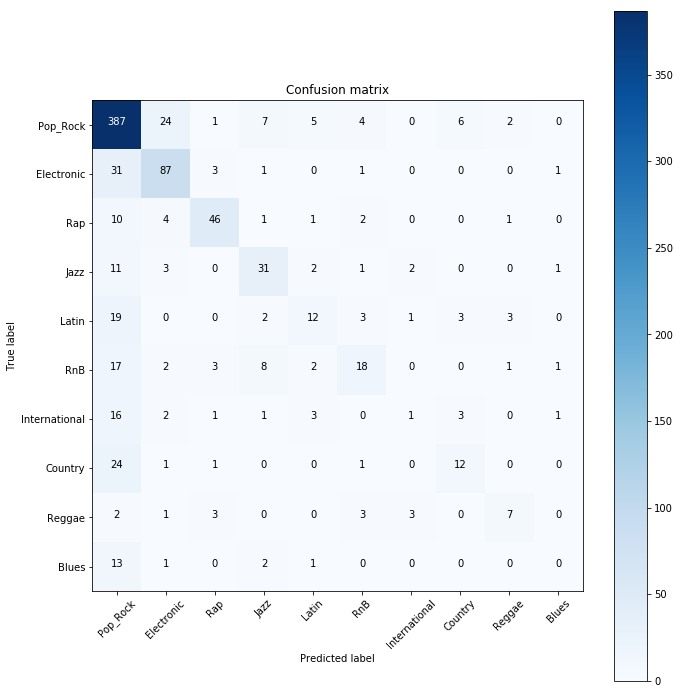

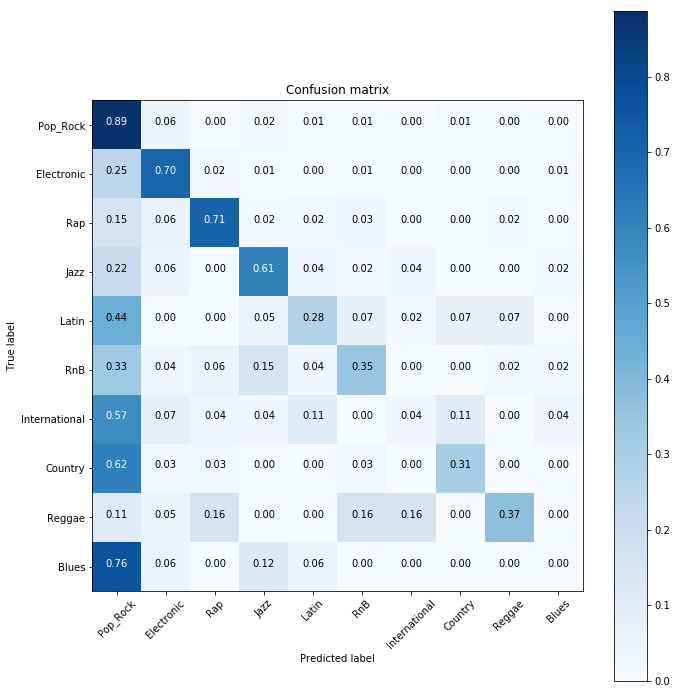

In [14]:
# Confusion matrix demo
class_names = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
plt.figure(figsize = (10, 10))
plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = False)
plt.figure(figsize = (10, 10))
plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = True)

In [ ]:
''' 
KNN Classifier Testing with Mutiple Iterations
'''
bestAcc = 0
bestK = 1
k_array = []
acc = []
for k in range(50):
    neigh = KNeighborsClassifier(n_neighbors = k + 1, n_jobs = -2)
    neigh.fit(XTrainSet, YTrainSet.ravel())
    predLabels = neigh.predict(XTestSet)
    conf = confusion_matrix(YTestSet, predLabels)
    accuracy = np.trace(conf) / np.sum(conf)
    k_array.append(k + 1)
    acc.append(accuracy)
    if acc >= bestAcc:
        bestAcc = acc
        bestK = k
    print('Accuracy:', accuracy,'with', k + 1, 'neighbors')


In [ ]:
'''
Accuracy Plot for multiple KNN Classifications
'''

plt.figure()
plt.plot(k_array, acc)
plt.show()

In [ ]:
'''
Single KNN Classification (with best parameters)
'''

neigh = KNeighborsClassifier(n_neighbors = bestK + 1, n_jobs = -2)
neigh.fit(XTrainSet, YTrainSet.ravel())
predLabels = neigh.predict(XTestSet)
conf = confusion_matrix(YTestSet, predLabels)
accuracy = np.trace(conf) / np.sum(conf)
print('Accuracy:', accuracy)
logloss = neigh.predict_proba(XTestSet)

In [ ]:
clf = Perceptron(shuffle = True, tol = 1e-3, max_iter = 1000, random_state = 16)
clf.fit(XTrainSet, YTrainSet.ravel())
print(clf.score(XTrainSet, YTrainSet.ravel()))
print(clf.score(XTestSet, YTestSet.ravel()))

In [ ]:
# Load the data and cleanup

In [ ]:
#Analysis of the input data
# ...

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [ ]:
# Trials with ML algorithms

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [ ]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *